# Chap16 - 강화학습 (Reinforcement Learning)

이번 포스팅에서는 게임 뿐만아니라 보행 로봇, 자율주행 자동차 등 다양한 분야에서 사용되는 **강화학습**(RL, Reinforcement Learning)에 대해 알아보도록 하자.

## 1. 보상을 최적화하기 위한 학습

강화학습에서 소프트웨어 **에이전트**(agent)는 **관측**(observation)을 하고 주어진 **환경**(environment)에서 **행동**(action)한다. 그리고 그 결과로 **보상**(reward)을 받는다(그림 출처: [wikipedia](https://en.wikipedia.org/wiki/Reinforcement_learning)).



![](./images/rl.png)



에이전트의 목적은 보상의 장기간(long-term) 기대치를 최대로 만드는 행동을 학습하는 것이다. 즉, 에이전트는 환경안에서 행동하고 시행착오를 통해 보상이 최대가 되도록 학습한다. 

이러한 강화학습의 정의는 다음과 같이 다양한 문제에 적용할 수 있다는 것을 보여준다.

- **a** : 보행 로봇(walking robot)에서는 에이전트(agent)는 보행 로봇을 제어하는 프로그램일 수 있다. 이 때 환경(environment)은 실제 세상이고, 에이전트는 카메라나 센서등을 통해 환경을 관찰(observation)한다. 그런 다음 걷는 행동(action)을 한다. 엥전트는 목적지에 도착할 때 양수(positive)보상을 받고, 잘못된 곳으로 가거나 넘어질 때 음수(negative) 보상(패널티)을 받는다.
- **b** : 팩맨(pac-man)이라는 게임에서는 에이전트는 팩맨을 제어하는 프로그램이다. 환경은 게임상의 공간이고, 행동은 조이스틱의 방향이 된다. 관측은 스크린샷이 되고 보상은 게임의 점수이다.
- **c** : 에이전트는 주식시장의 가격을 관찰하고 행동은 얼마나 사고팔아야 할지 결정하는 것이며, 보상은 수익과 손실이 된다.



![](./images/rl02.PNG)

## 2. 정책 탐색 (Policy Search)

에이전트(agent)가 행동(action)을 결정하기 위해 사용하는 알고리즘을 **정책(policy)**이라고 한다. 예를 들어 관측(observation)을 입력으로 받고 행동(action)을 출력하는 신경망이 정책이 될 수 있다.



![](./images/rl03.PNG)



정책은 정해져 있는 알고리즘이 아니기 때문에, 어떠한 알고리즘도 될 수 있다. 예를들어 30분 동안 수집한 먼지의 양을 보상으로 받는 로봇 청소기가 있다고 하자. 이 청소기의 정책은 매 초마다 어떤 확률 $p$ 만큼 전진할 수도 있고, 또는 ($1-p$)의 확률로 랜덤하게 $-r$과 $+r$ 사이에서 회전하는 것일 수도 있다. 이 정책에는 무작위성이 포함되어 있으므로 **확률적 정책**(stochastic policy)라고 한다.

이러한 정책을 가지고 '30분 동안 얼마나 많은 먼지를 수집할 것인가'에 대한 문제를 해결하기 위해 어떻게 로봇 청소기를 훈련(training) 시킬 수 있을까? 로봇 청소기 예제에는 변경이 가능한 두 개의 **정책 파라미터**(policy parameter)가 있는데, 확률 $p$와 각도의 범위  $r$이다. $p$와 $r$은 다양한 조합이 될 수 있는데 이처럼 정책 파라미터의 범위를 **정책 공간**(policy space)라고 하며, 정책 공간에서 가장 성능이 좋은 파라미터를 찾는 것을 **정책 탐색**(policy search)라고 한다. 

정책 탐색에는 다음과 같은 방법들이 있다.

- **단순한(naive) 방법** : 다양한 파라미터 값들로 실험한 뒤 가장 성능이 좋은 파라미터를 선택한다.
- **유전 알고리즘(genetic algorithm)** :  기존의 정책(부모)에서 더 좋은 정책(자식)을 만들어 내는 과정(진화)를 통해서 좋은 정책을 찾을 때까지 반복하는 방법이다.
- **정책 그래디언트(PG, policy gradient)** : 정책 파라미터에 대한 보상(reward)의 그래디언트(gradient)를 평가해서 높은 보상의 방향을 따르는 그래디언트로(**gradient ascent**) 파라미터를 업데이트하는 최적화 방법이다.

### Set Up

In [1]:
import os, sys
import numpy as np
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
# matplotlib.rc('font', family='NanumBarunGothic') # Linux
plt.rcParams['axes.unicode_minus'] = False

## 3. OpenAI Gym

강화학습에서 중요한 요소 중 하나는 에이전트(agent)를 훈련시키기 위한 **시뮬레이션 환경**이 필요하다.

**[OpenAI Gym](http://gym.openai.com)**은 다양한 종류의 시뮬레이션 환경(아타리 게임, 보드 게임, 물리 시뮬레이션 등)을 제공하는 툴킷이며, 이를 이용하여 에이전트를 훈련시키고 RL 알고리즘을 개발할 수 있다.

OpenAI Gym의 설치는 다음과 같이 `pip`명령을 통해 설치할 수 있다.

```bash
pip install --upgrade gym
```

In [2]:
import gym

env = gym.make("CartPole-v0")
obs = env.reset()
print('obs.shape :', obs.shape)
print('obs :', obs)

obs.shape : (4,)
obs : [ 0.01108219  0.0056951  -0.01854807 -0.00028084]


In [3]:
from render_notebook import render_cart_pole

def plot_cart_pole(env, obs):
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

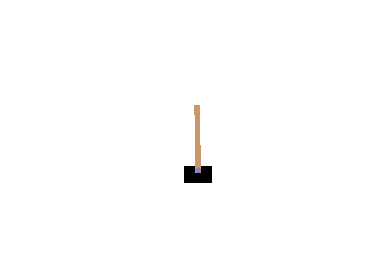

In [4]:
plot_cart_pole(env, obs)

In [5]:
env.action_space

Discrete(2)

In [6]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

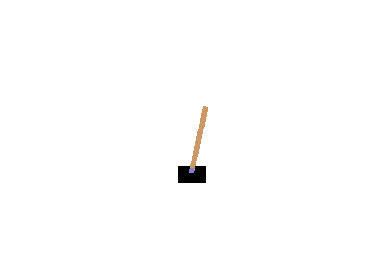

In [7]:
img = render_cart_pole(env, obs)
plt.axis("off")
plt.imshow(img);

In [8]:
img.shape

(400, 600, 3)